In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

In [2]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [3]:
print("▶ train.csv shape:", train.shape)
print("▶ test.csv  shape:", test.shape)

▶ train.csv shape: (1460, 81)
▶ test.csv  shape: (1459, 80)


In [4]:
print(train.info())
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
missing = train.isnull().sum().sort_values(ascending=False)
print("Top 10 features with missing values:\n", missing[missing > 0].head(10))

Top 10 features with missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64


In [6]:
print("\nSalePrice summary:\n", train["SalePrice"].describe())


SalePrice summary:
 count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


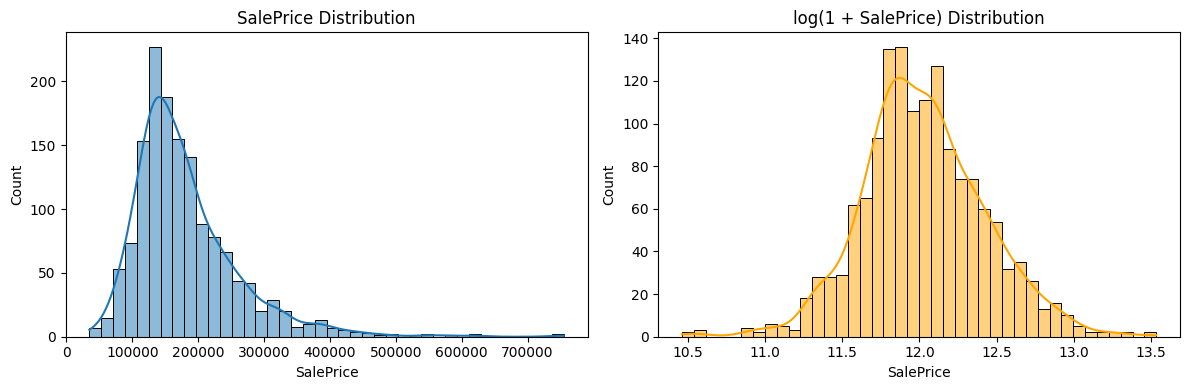

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train["SalePrice"], bins=40, kde=True)
plt.title("SalePrice Distribution")
plt.subplot(1,2,2)
sns.histplot(np.log1p(train["SalePrice"]), bins=40, kde=True, color="orange")
plt.title("log(1 + SalePrice) Distribution")
plt.tight_layout()
plt.show()


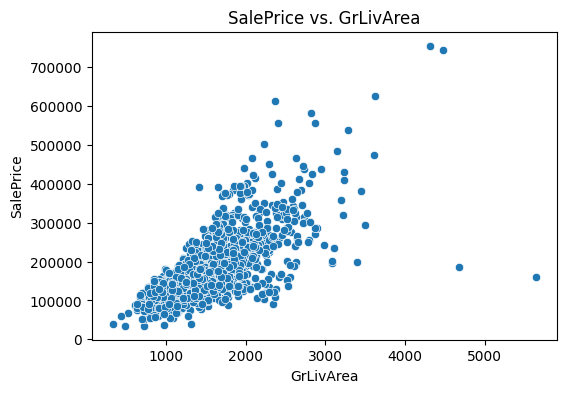

In [8]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=train)
plt.title("SalePrice vs. GrLivArea")
plt.show()

In [10]:
y = np.log1p(train["SalePrice"])
train_IDs = train["Id"]
test_IDs  = test["Id"]

X = train.drop(columns=["Id", "SalePrice"])
X_test = test.drop(columns=["Id"])


In [11]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='constant', fill_value='Missing')

X[num_cols]     = num_imp.fit_transform(X[num_cols])
X_test[num_cols]= num_imp.transform(X_test[num_cols])

X[cat_cols]     = cat_imp.fit_transform(X[cat_cols])
X_test[cat_cols]= cat_imp.transform(X_test[cat_cols])


num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='constant', fill_value='Missing')

X[num_cols]     = num_imp.fit_transform(X[num_cols])
X_test[num_cols]= num_imp.transform(X_test[num_cols])

X[cat_cols]     = cat_imp.fit_transform(X[cat_cols])
X_test[cat_cols]= cat_imp.transform(X_test[cat_cols])


In [14]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ('prep',   preprocessor),
    ('ridge',  RidgeCV(alphas=[0.1,1.0,10.0]))
])

cv_scores = -cross_val_score(
    pipeline, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
print(f'CV RMSE: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

pipeline.fit(X, y)
preds = np.expm1(pipeline.predict(X_test))

submission = pd.DataFrame({'Id': test_IDs, 'SalePrice': preds})
submission.to_csv('submission.csv', index=False)



CV RMSE: 0.1396 ± 0.0252


In [15]:
# 7.1 – Identify skewed numeric features
from scipy.stats import skew

# num_cols still defined from before
skewness = X[num_cols].apply(lambda col: skew(col.dropna()))
skewed_feats = skewness[abs(skewness) > 0.75].index.tolist()

# 7.2 – Log-transform those skewed features
for feat in skewed_feats:
    X[feat]      = np.log1p(X[feat])
    X_test[feat] = np.log1p(X_test[feat])

# 7.3 – Create TotalSF and HouseAge
for df in (X, X_test):
    df["TotalSF"]  = df["GrLivArea"] + df["TotalBsmtSF"]
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]

# 7.4 – Refresh feature lists
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# 7.5 – Rebuild preprocessor & pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

pipeline = Pipeline([
    ("prep",  preprocessor),
    ("ridge", RidgeCV(alphas=[0.1, 1.0, 10.0])),
])

# 7.6 – Re-run CV
cv_scores = -cross_val_score(
    pipeline, X, y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
print(f"CV RMSE after FE: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


CV RMSE after FE: 0.1265 ± 0.0156


In [17]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# 8.1 – Build a new pipeline with LightGBM
lgbm_pipeline = Pipeline([
    ("prep",  preprocessor),   # from your Step 7
    ("model", lgb.LGBMRegressor(
        objective="regression",
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42
    ))
])

# 8.2 – 5-fold CV RMSE
cv_scores_lgb = -cross_val_score(
    lgbm_pipeline, X, y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
print(f"LGBM CV RMSE: {cv_scores_lgb.mean():.4f} ± {cv_scores_lgb.std():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 198
[LightGBM] [Info] Start training from score 12.021409


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3589
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 194
[LightGBM] [Info] Start training from score 12.023288


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3584
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 197
[LightGBM] [Info] Start training from score 12.020737


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 195
[LightGBM] [Info] Start training from score 12.032956


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3589
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 196
[LightGBM] [Info] Start training from score 12.021897


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBM CV RMSE: 0.1284 ± 0.0069


In [19]:
!pip install optuna --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 11.3 MB/s eta 0:00:00


In [20]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb
from sklearn.pipeline import Pipeline


In [21]:

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 20000, step=1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128, step=16),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100, step=5),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "random_state": 42
    }
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", lgb.LGBMRegressor(**params))
    ])
    cv = KFold(5, shuffle=True, random_state=42)
    scores = -cross_val_score(
        pipe, X, y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    return scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best CV RMSE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-07-22 15:03:31,186] A new study created in memory with name: no-name-b8ffa614-26e1-41de-9761-e355420ebe9b
/tmp/ipython-input-21-3024717267.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/tmp/ipython-input-21-3024717267.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
/tmp/ipython-input-21-3024717267.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("sub

Best CV RMSE: 0.12854041073076322
Best params: {'n_estimators': 10000, 'learning_rate': 0.0010263721990132046, 'num_leaves': 16, 'colsample_bytree': 0.6493867732239968, 'subsample': 0.8896660837325551, 'min_child_samples': 5, 'reg_alpha': 1.2221465775902207e-08, 'reg_lambda': 1.5818342703792957e-06}


In [22]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline


best_params = {
    'n_estimators':       10000,
    'learning_rate':      0.0010263721990132046,
    'num_leaves':         16,
    'colsample_bytree':   0.6493867732239968,
    'subsample':          0.8896660837325551,
    'min_child_samples':  5,
    'reg_alpha':          1.2221465775902207e-08,
    'reg_lambda':         1.5818342703792957e-06,
    'random_state':       42
}


final_lgbm = Pipeline([
    ("prep",  preprocessor),
    ("model", lgb.LGBMRegressor(**best_params))
])


final_lgbm.fit(X, y)

preds_lgbm = np.expm1(final_lgbm.predict(X_test))


submission = pd.DataFrame({
    "Id":        test_IDs,
    "SalePrice": preds_lgbm
})
submission.to_csv("submission_lgbm_final.csv", index=False)
print("Wrote submission_lgbm_final.csv")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3977
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 256
[LightGBM] [Info] Start training from score 12.024057


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Wrote submission_lgbm_final.csv
